# Machine Learning for Customer Analysis for Sure Tomorrow Insurance Company

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import math
import re
import sklearn

from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from IPython.display import display
import warnings

import warnings
warnings.filterwarnings('ignore')

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [3]:
# Replace spaces with underscores and convert all column names to lowercase
df.columns = [re.sub(r'\s+', '_', col).lower() for col in df.columns]

In [4]:
# Display the first 5 rows of the DataFrame
df.head()

,gender,age,salary,family_members,insurance_benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [5]:
# Display the informative summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   salary              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# Convert the 'age' and 'income' columns to integer type.
df['age'] = df['age'].astype(int)
df['salary'] = df['salary'].astype(int)

In [7]:
# Check the data type of the 'age' and 'salary' columns
df[['age', 'salary']].dtypes

age       int32
salary    int32
dtype: object

In [8]:
# Display the descriptive statistics of the dataset
df.describe()

,gender,age,salary,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.359400,1.194200,0.148000
std,0.500049,8.440807,9900.082063,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [9]:
# Display the number of duplicates in the dataset
df.duplicated().sum()

153

In [10]:
# Display the number of missing values in the dataset
df.isnull().isna().sum()

gender                0
age                   0
salary                0
family_members        0
insurance_benefits    0
dtype: int64

There are 153 duplicates found in 'df' dataset, which I kept it as it is, as dropping then were resulting into NaNs when running codes to calculate distances using different metrics.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

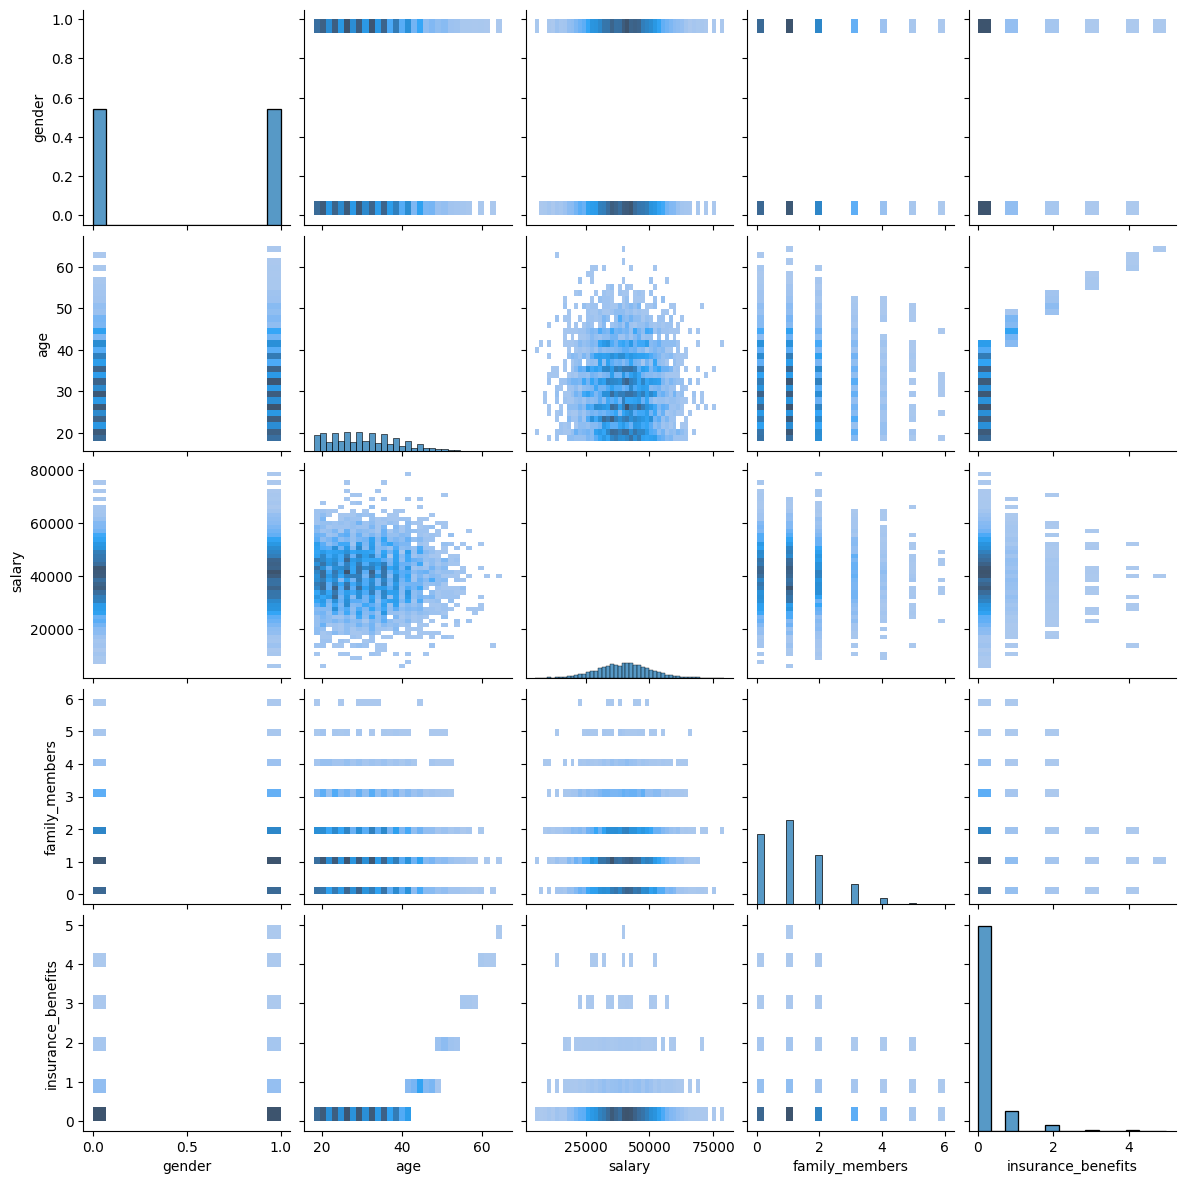

In [11]:
# Create a pairwise plot of the DataFrame's numeric features using histograms instead of scatterplots
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [12]:
# Define the list of feature (independent variable) column names to be used in modeling or analysis
feature_names = ['gender', 'age', 'salary', 'family_members']

In [13]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    # Initialize the NearestNeighbors model with given metric and number of neighbors
    nbrs = NearestNeighbors(
        n_neighbors=k, 
        algorithm='auto', 
        leaf_size=30, 
        metric=metric
        )
    
    # Fit the model on the selected feature columns
    nbrs.fit(df[feature_names]) 
    
    # Find distances and indices of k nearest neighbors to the object at index n
    nbrs_distances, nbrs_indices = nbrs.kneighbors(
        [df.iloc[n][feature_names]],
        k, 
        return_distance=True
        )
    
    # Build the result DataFrame by combining the neighbors and their distances
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, 
                     index=nbrs_indices[0], 
                     columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [14]:
# Initialize and fit a MaxAbsScaler on the selected feature columns.
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

# Create a copy of the original DataFrame to store the scaled features
df_scaled = df.copy()

# Apply the scaling transformation to the selected features and assign them back to the copied DataFrame
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [15]:
# Display a random sample of 5 rows from the scaled DataFrame to inspect the transformed data
df_scaled.sample(5)

,gender,age,salary,family_members,insurance_benefits
3457,0,0.446154,0.427848,0.000000,0
2938,0,0.369231,0.453165,0.333333,0
34,0,0.292308,0.820253,0.333333,0
1531,0,0.584615,0.724051,0.333333,0
3673,0,0.523077,0.178481,0.166667,0


Now, let's get similar records for a given one for every combination

In [16]:
# Index of the target object for which neighbors are searched
n = 0

# Number of nearest neighbors to find
k = 5

In [17]:
# unscaled data

# Find k nearest neighbors of the object at index n using unscaled data with Euclidean distance
euclidean_unscaled = get_knn(df, n, k, metric='euclidean')

# Find k nearest neighbors of the object at index n using unscaled data with Manhattan distance
manhattan_unscaled = get_knn(df, n, k, metric='manhattan')

In [18]:
# scaled data

# Find k nearest neighbors of the object at index n using scaled data with Euclidean distance
euclidean_scaled = get_knn(df_scaled, n, k, metric='euclidean')

# Find k nearest neighbors of the object at index n using scaled data with Manhattan distance
manhattan_scaled = get_knn(df_scaled, n, k, metric='manhattan')

In [19]:
# Display the results for all four cases to compare the effects of scaling and metric choice
display('Euclidean (UnScaled):', euclidean_unscaled)
display('Manhattan (UnScaled):', manhattan_unscaled)
display('Euclidean (Scaled):', euclidean_scaled)
display('Manhattan (Scaled):', manhattan_scaled)

'Euclidean (UnScaled):'

,gender,age,salary,family_members,insurance_benefits,distance
0,1,41,49600,1,0,0.000000
2022,1,41,49600,0,0,1.000000
1225,0,42,49600,0,1,1.732051
4031,1,44,49600,2,1,3.162278
3424,0,38,49600,0,0,3.316625


'Manhattan (UnScaled):'

,gender,age,salary,family_members,insurance_benefits,distance
0,1,41,49600,1,0,0.0
2022,1,41,49600,0,0,1.0
1225,0,42,49600,0,1,3.0
4031,1,44,49600,2,1,4.0
815,1,37,49600,2,0,5.0


'Euclidean (Scaled):'

,gender,age,salary,family_members,insurance_benefits,distance
0,1,0.630769,0.627848,0.166667,0,0.000000
2689,1,0.630769,0.634177,0.166667,0,0.006329
133,1,0.615385,0.636709,0.166667,0,0.017754
4869,1,0.646154,0.637975,0.166667,1,0.018418
3275,1,0.646154,0.651899,0.166667,1,0.028550


'Manhattan (Scaled):'

,gender,age,salary,family_members,insurance_benefits,distance
0,1,0.630769,0.627848,0.166667,0,0.000000
2689,1,0.630769,0.634177,0.166667,0,0.006329
133,1,0.615385,0.636709,0.166667,0,0.024245
4869,1,0.646154,0.637975,0.166667,1,0.025511
2103,1,0.630769,0.596203,0.166667,0,0.031646


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Yes, the data being not scaled does affect the kNN algorithm. In unscaled data, featues (columns) like income; will dominate the distance calcuations while features like gender and insurance benefits will contribute much less. 

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Even though Manhattan distance treats each feature independently and sums the absolute difference, still the results using the Manhattan distance metric were not consistent. Out of 5 nearest neighbors, none of those are similar among Manhattan distance metric. Also, Manhattan distance is less sensitive to outliers compa

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influence the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [20]:
# Create a new binary target column 'insurance_benefits_received' to the 'df' DataFrame. 
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)

In [21]:
# Add a new binary target column 'insurance_benefits_received' to the scaled DataFrame.
df_scaled['insurance_benefits_received'] = (df_scaled['insurance_benefits'] > 0).astype(int)

In [22]:
# Check for the class imbalance in the 'insurance_benefits_received' target column
df['insurance_benefits_received'].value_counts(normalize=True)

insurance_benefits_received
0    0.8872
1    0.1128
Name: proportion, dtype: float64

In [23]:
# Evaluate classifier by printing F1 score and normalized confusion matrix
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [24]:
# Generate random binary predictions simulating a random model with probability P of predicting 1
def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [25]:
# Evaluate random model predictions with different probabilities P
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:
 
    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df), seed=42)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [26]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    
    df[feature_names], 
    df['insurance_benefits_received'], 
    test_size=0.3, 
    random_state=57
    )


In [27]:
# Train and evaluate KNN classifiers with k from 1 to 9
for n in range(1,10):
    
    neigh = KNeighborsClassifier(n_neighbors=n, weights='uniform', algorithm='auto', 
                                                 leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
    neigh.fit(X_train, y_train)


    y_test_pred = neigh.predict(X_test)
    eval_classifier(y_test, y_test_pred)

F1: 0.64
Confusion Matrix
[[0.87866667 0.018     ]
 [0.046      0.05733333]]
F1: 0.38
Confusion Matrix
[[0.89333333 0.00333333]
 [0.078      0.02533333]]
F1: 0.44
Confusion Matrix
[[0.884      0.01266667]
 [0.07066667 0.03266667]]
F1: 0.26
Confusion Matrix
[[0.89533333 0.00133333]
 [0.088      0.01533333]]
F1: 0.27
Confusion Matrix
[[0.894      0.00266667]
 [0.08666667 0.01666667]]
F1: 0.09
Confusion Matrix
[[0.89666667 0.        ]
 [0.09866667 0.00466667]]
F1: 0.08
Confusion Matrix
[[0.89333333 0.00333333]
 [0.09866667 0.00466667]]
F1: 0.03
Confusion Matrix
[[0.89666667 0.        ]
 [0.102      0.00133333]]
F1: 0.03
Confusion Matrix
[[8.96000000e-01 6.66666667e-04]
 [1.02000000e-01 1.33333333e-03]]


Without feature scaling, the F1 score are quite low, ranging from 0.03 to 0.64. As the number of neighbors increases, performance significantly declines. The confusion matrices show a strong bias toward predicting the majority class of ones not recieving insurance benefits. 

In [28]:
# Scale features using MaxAbsScaler: fit on training data and transform both train and test sets
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit only on training data
X_test_scaled = scaler.transform(X_test)

In [29]:
# Train and evaluate KNN with k=1 to 9 on scaled data
for n in range(1,10):
    
    neigh = KNeighborsClassifier(
        n_neighbors=n,
        weights='uniform', 
        algorithm='auto', 
        leaf_size=30, 
        p=2, 
        metric='minkowski', 
        metric_params=None, 
        n_jobs=None
        )
    
    neigh.fit(X_train_scaled, y_train)
    y_test_pred_scaled = neigh.predict(X_test_scaled)
    eval_classifier(y_test, y_test_pred_scaled)

F1: 0.96
Confusion Matrix
[[0.89133333 0.00533333]
 [0.00333333 0.1       ]]
F1: 0.95
Confusion Matrix
[[0.89533333 0.00133333]
 [0.00933333 0.094     ]]
F1: 0.95
Confusion Matrix
[[0.89333333 0.00333333]
 [0.00666667 0.09666667]]
F1: 0.94
Confusion Matrix
[[8.96000000e-01 6.66666667e-04]
 [1.20000000e-02 9.13333333e-02]]
F1: 0.94
Confusion Matrix
[[0.894      0.00266667]
 [0.00933333 0.094     ]]
F1: 0.93
Confusion Matrix
[[0.89533333 0.00133333]
 [0.01266667 0.09066667]]
F1: 0.93
Confusion Matrix
[[0.894      0.00266667]
 [0.01066667 0.09266667]]
F1: 0.93
Confusion Matrix
[[0.89533333 0.00133333]
 [0.012      0.09133333]]
F1: 0.93
Confusion Matrix
[[0.894      0.00266667]
 [0.01066667 0.09266667]]


With feature scaling, the F1 scores drastically improve, 0.93 to 0.96 compared to that of without feature scaling. The confusion matrices indicate better classification with more balanced predictions between classes. The model generalizes much better compared to the unscaled ones. 

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [30]:
# Simple linear regression model using the Normal Equation for fitting and prediction
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [31]:
# Evaluate regression performance by printing RMSE and R2 scores
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [32]:
# Prepare features and target arrays, then split data into training and testing sets
X = df[['age', 'gender', 'salary', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=12345
    )


In [33]:
# Create an instance of the linear regression model
lr = MyLinearRegression()

# Fit the model to the training data
lr.fit(X_train, y_train)

# Print the learned weights (coefficients)
print(lr.weights)

# Predict target values for the test set
y_test_pred = lr.predict(X_test)

# Evaluate and print regression metrics on test predictions
eval_regressor(y_test, y_test_pred)

[-9.43538930e-01  3.57495491e-02  1.64272730e-02 -2.60745684e-07
 -1.16902138e-02]
RMSE: 0.34
R2: 0.66


In [34]:
# Initialize MaxAbsScaler
scaler = MaxAbsScaler()

# Fit scaler on training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [35]:
# Fit model on scaled training data
lr.fit(X_train_scaled, y_train)

# Print model weights after training
print(lr.weights)

# Predict on scaled test data
y_test_pred_scaled = lr.predict(X_test_scaled)

 # Evaluate predictions with regression metrics
eval_regressor(y_test, y_test_pred_scaled)

[-0.94353893  2.32372069  0.01642727 -0.02059891 -0.07014128]
RMSE: 0.34
R2: 0.66


The above results indicate that scaling did not affect the models's predictive performance, as RMSE and R2 remain the same. The model weights change because scaling effects the scale of the input features. Since linear regression adjusts for these transformations internally, the final predictions remains the same and so does the RMSE and R2 of both datasets. 

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the invertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [36]:
# Define list of personal info columns
personal_info_column_list = ['gender', 'age', 'salary', 'family_members']

# Create new DataFrame with selected columns
df_pn = df[personal_info_column_list]

In [37]:
# Show the first few rows of the personal info DataFrame
display(df_pn.head())

,gender,age,salary,family_members
0,1,41,49600,1
1,0,46,38000,1
2,0,29,21000,0
3,0,21,41700,2
4,1,28,26100,0


In [38]:
# Convert the DataFrame to a NumPy array for modeling
X = df_pn.to_numpy()

# Display NumPy array
display(X)

array([[    1,    41, 49600,     1],
       [    0,    46, 38000,     1],
       [    0,    29, 21000,     0],
       ...,
       [    0,    20, 33900,     2],
       [    1,    22, 32700,     3],
       [    1,    28, 40600,     1]], dtype=int64)

Generating a random matrix $P$.

In [39]:
# Create a random number generator with a fixed seed for reproducibility
rng = np.random.default_rng(seed=42)

# Generate a random matrix of shape
P = rng.random(size=(X.shape[1], X.shape[1]))  

# Display a random matrix
print(P[:5])

[[0.77395605 0.43887844 0.85859792 0.69736803]
 [0.09417735 0.97562235 0.7611397  0.78606431]
 [0.12811363 0.45038594 0.37079802 0.92676499]
 [0.64386512 0.82276161 0.4434142  0.22723872]]


Checking the matrix $P$ is invertible

In [40]:
try:
    # Try to compute the inverse of matrix P
    P_inv = np.linalg.inv(P)
    print("The matrix is invertible")
except np.linalg.LinAlgError:
    print("The matrix is NOT invertible.")

The matrix is invertible


Can you guess the customers' ages or income after the transformation?

After the transformation, if the values in these features look completely random, then obfuscation is working. If one can see the trends, the obfuscation is not good enough. 

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

Yes, one can recover the original data from $X'$ if one knows $P$ in the equation. 

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [41]:
# Display the first 5 rows of the NumPy array X
print("Original Data:")
print(X[:5])

Original Data:
[[    1    41 49600     1]
 [    0    46 38000     1]
 [    0    29 21000     0]
 [    0    21 41700     2]
 [    1    28 26100     0]]


In [42]:
# Apply linear transformation by multiplying X with matrix P
X_prime = X.dot(P)

# Display first 5 rows of the transformed data
print("Transformed Data:")
display(X_prime[:5])

Transformed Data:


array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       [ 5345.60393712, 18803.22720286, 15479.14837264, 38663.06186284],
       [ 3347.17673462, 11782.82928336,  9699.99894205, 24211.27337753]])

In [43]:
# Calculate inverse of matrix P
P_inv = np.linalg.inv(P)

# Recover original data by multiplying transformed data by inverse of P
X_recovered = X_prime.dot(P_inv)

# Display first 5 rows of recovered data
print("Recovered Data:")
print(X_recovered[:5])

Recovered Data:
[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-5.00222086e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-3.63797881e-12  2.90000000e+01  2.10000000e+04 -9.09494702e-13]
 [-5.45696821e-12  2.10000000e+01  4.17000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  2.61000000e+04  3.18323146e-12]]


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

Yes, some values are not exactly the same as they are in original data. This can be due to floating-point precision errors which can result in rounding errors when performing calculations. Along with it, matrix inversion approximation can be the reason as calculating the inverse of a matrix is not always exact due to the numerical calculations. 

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer: Analytical Proof**

The solution for the weight vector $w$ is: 
$$w = (X^T X)^{-1} X^T y$$

Instead of using $X$, the data is transformed using an invertible matrix $P$: 
$$X' = XP$$

Now, to find $w_P$, in this formula, $w_P = (X'^T X)^{-1} X'^T y$, substitute $X' = XP$ :
$$w_P = [(XP)^T XP]^{-1} (XP)^T y$$

Using Reversivity of Transpose: $$(A B)^T = B^T A^T$$
$$(X P)^T = P^T X^T$$

Thus,
$$w_P = (P^T X^T X P)^{-1} P^T X^T y$$

The transformed weight vector $w_P$ is related to the original weight vector $w$ by the inverse of the transformation matrix P. This shows that the obfuscation process does not affect linear regression in terms of predicted values.


Using the Inverse of a Product Rule: 
$$(AB)^{-1} = B^{-1}A^{-1}$$

Applying this to $[(XP)^T XP]^{-1}$ will give the equation below, 
$$w_P = P^{-1} (X^T X)^{-1} P^{-T} P^T X^T y$$

Since $( P^{-T} P^T = I$ (Identity Matrix Property):
$$w_P = P^{-1} (X^T X)^{-1} X^T y$$

From the original formula $( w = (X^T X)^{-1} X^T y$, its concluded that:
$$w_P = P^{-1} w$$
                            
The predicted values with $w_P$ remain the same which means that the transformation has no effect on the predictions made by the model.

Predicted values in the original model:
$$\hat{y} = X w$$

Predicted values in the obfuscated model:
$$\hat{y}' = X' w_P$$

Substituting $X' = X P$ and $w_P = P^{-1} w$:
$$\hat{y}' = X P P^{-1} w$$

Using the Multiplicative Identity Property:
$$P P^{-1} = I$$
$$\hat{y}' = X w$$

Thus,
$$\hat{y}' = \hat{y}$$

RMSE means the average predictions error, as mentioned in the above question the predictions made by the model would be same, RMSE remains exactly the same. 

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Multiply the original feature matrix $X$ by $P$ to obtain $XP$.
- Use $XP$ as the new feature matrix

In [44]:
# Initialize random number generator with seed 7 for reproducibility
rng = np.random.default_rng(seed=7)

# Create a random square matrix of size equal to number of features in X
P = rng.random(size=(X.shape[1], X.shape[1]))

In [45]:
# Display the first 5 rows of matrix P
print(P[:5])

[[0.62509547 0.8972138  0.77568569 0.22520719]
 [0.30016628 0.87355345 0.0052653  0.82122842]
 [0.79706943 0.46793495 0.30303243 0.27842561]
 [0.25486959 0.44507631 0.50454826 0.55349735]]


In [46]:
# Attempt to compute the inverse of matrix P
try:
    P_inv = np.linalg.inv(P)
    print("The matrix is invertible")
except np.linalg.LinAlgError:
    print("The matrix is NOT invertible.")

The matrix is invertible


In [47]:
# Display the first 5 rows of the original data matrix X
print("Original Data:")
print(X[:5])

Original Data:
[[    1    41 49600     1]
 [    0    46 38000     1]
 [    0    29 21000     0]
 [    0    21 41700     2]
 [    1    28 26100     0]]


In [48]:
# Apply a linear transformation to the original data using matrix P
X_prime = X.dot(P)

# Display the first 5 rows of the transformed data
print("Transformed Data:")
print(X_prime[:5])

Transformed Data:
[[39547.83044884 23246.73164242 15031.90448167 13844.35942989]
 [30302.70081127 17822.15674286 11515.9789714  10618.50326443]
 [16747.16282606  9851.96705963  6363.83365704  5870.75347825]
 [33244.60841012 19532.12230855 12637.57186628 11628.70081609]
 [20812.54184187 12238.45897949  7910.0694542   7290.12807873]]


In [49]:
# Compute the inverse of the transformation matrix P
P_inv = np.linalg.inv(P)

# Recover the original data by reversing the transformation
X_recovered = X_prime.dot(P_inv)

# Display the first 5 rows of the recovered data
print("Recovered Data:")
print(X_recovered[:5])

Recovered Data:
[[1.00000000e+00 4.10000000e+01 4.96000000e+04 1.00000000e+00]
 [0.00000000e+00 4.60000000e+01 3.80000000e+04 1.00000000e+00]
 [9.09494702e-13 2.90000000e+01 2.10000000e+04 0.00000000e+00]
 [1.09139364e-11 2.10000000e+01 4.17000000e+04 2.00000000e+00]
 [1.00000000e+00 2.80000000e+01 2.61000000e+04 0.00000000e+00]]


In [50]:
# Simple linear regression model using the Normal Equation for fitting and prediction
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [51]:
 # Evaluate regression performance by printing RMSE and R2 scores
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [52]:
# Select features and target
X = df[['age', 'gender', 'salary', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=7
    )

# Initialize linear regression model
lr = MyLinearRegression()

# Train the model on training data
lr.fit(X_train, y_train)

# Print learned weights
print(lr.weights)

# Predict on test data
y_test_pred = lr.predict(X_test)

# Evaluate predictions using regression metrics
eval_regressor(y_test, y_test_pred)

[-9.68028971e-01  3.68125120e-02  8.58684316e-03 -3.38858957e-07
 -1.08016562e-02]
RMSE: 0.33
R2: 0.64


In [53]:
# Split the obfuscated data into training and testing sets
X_train_prime, X_test_prime, y_train, y_test = train_test_split(
    X_prime, 
    y, 
    test_size=0.3, 
    random_state=7
    )

# Initialize the linear regression model
lr_obfuscated = MyLinearRegression()

# Train the model on the transformed (obfuscated) training data
lr_obfuscated.fit(X_train_prime, y_train)

# Print learned weights
print(lr_obfuscated.weights)

# Predict on the transformed (obfuscated) test data
y_test_pred_obfuscated = lr_obfuscated.predict(X_test_prime)

# Evaluate predictions
eval_regressor(y_test, y_test_pred_obfuscated)

[-0.96802895 -0.01282736  0.06757678 -0.05035667 -0.02204494]
RMSE: 0.33
R2: 0.64


Hence, based on the above example it is proved that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same and thus RMSE remain the same.

# Conclusions

The project is based on to solve several tasks for The Sure Insurance Company with the help of Machine Learning along with evaluating the possibility. For this, firstly data preprocessing and exploration was done in which it was known that the dataset consists of 153 duplicates and 0 missing values.

 For first task, a procedure was developed that returns 5 nearest neighbors for a give object based on the distance between the object. To check the procedure which was developed, it was tested using four combination of two cases thast includes unscaled and scaled data, measured using euclidean and manhattan distance metrics. This shows that the algorithm works successfully and known that whether the data is scaled or not did not make any difference in the RMSE. 

 For second task, a KNN-based classifier was build to determine if customer is likely to recieve insurance benefit and F1 metric was used to measure its qualilty. Along with this a dummy model was developed to test the model with four probability values: 0, 0.5, 1, and the probability of paying any insurance benefit. With this dummy model, a KNN-based classifier was successfuly tested for both original and scaled datasets. The results shows the impact of feature scaling on the performace of KNN Classifier when predicting whether insurance benefits were received. Without feature scaling, the F1 score are quite low, ranging from 0.03 to 0.64. As the number of neighbors increases, performance significantly declines. The confusion matrices show a strong bias toward predicting the majority class of ones not recieving insurance benefits. With feature scaling, the F1 scores drastically improve, 0.93 to 0.96 compared to that of without feature scaling. The confusion matrices indicate better classification with more balanced predictions between classes. As KNN relies on distance calculations and if features have different ranges such as income in thousands and age in tens, the larger-scale features dominate the distance metric. Thus, scaling ensures all features contribute equally, leading to better classification performance and so, feature scaling is essential for distance-based models like KNN. Without it, the classifier struggles to differentiate between classes, leading to poor performance. 

 For third task, class of LR was developed and RMSE for a Linear Regression model was evaluated using original dataset and scaled dataset. When testing the model by running for two different datasets, it was known that scaling did not affect the models's predictive performance, as RMSE and R2 remain the same. The model weights change because scaling effects the scale of the input features. Since linear regression adjusts for these transformations internally, the final predictions remains the same and so does the RMSE and R2 of both datasets.

 Lastly for fourth task, first an obfuscate data was developed and then the original data was recovered from an obfuscate data using analytical proof without affecting linear regression - that is the predicted values remained the same. Following this, a class is build that runs Linear Regression with the obfuscation for the original data and the obfuscated data to determine if the predicted values and the RMSE metric values change. After building a procedure and running it for two datasets, original and obfuscated data, it was known that there was no difference between RMSE metric values of both datasets. This supported the analysis and showed that the data was successfully obfuscated and that the original data was successfully recovered from obfuscated data. 

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells are arranged in order of logic and execution
- [x]  Task 1 has been performed
    - [x]  There is the procedure that can return k similar customers for a given one
    - [x]  The procedure is tested for all four proposed combinations
    - [x]  The questions re the scaling/distances are answered
- [x]  Task 2 has been performed
    - [x]  The random classification model is built and tested for all for probability levels
    - [x]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [x]  Task 3 has been performed
    - [x]  The linear tegression solution is implemented with matrix operations.
    - [x]  RMSE is calculated for the implemented solution.
- [x]  Task 4 has been performed
    - [x]  The data is obfuscated with a random and invertible matrix P
    - [x]  The obfuscated data is recoved, few examples are printed out
    - [x]  The analytical proof that the transformation does not affect RMSE is provided 
    - [x]  The computational proof that the transformation does not affect RMSE is provided
- [x]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>